1234, pdf

In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
import operator
import os
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv
import jj_basic_fn as JJ
import prep
#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', -1)

n_classifier = 7

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [50]:
def parameter_tuning(X_train, X_test, y_train, y_test, classifier, patid, C_range_num = 30, 
                     nfold = 10, if_save = 0, if_show = 1):
    #defs is a dictionary to initiate classifier with the parameters that don't need to be tuned
    defs = {}
    defs['classifier'] = classifier
    
    num_instances, num_features = X_train.shape[0], X_train.shape[1]
    n_fold = 10

    skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
    CV = skf.split(np.zeros(len(y_train)), y_train)
    
    prepath = '../estimators/'+str(patid) + '/'
    if not os.path.exists(prepath):
        os.makedirs(prepath)
    if classifier==1:
        clf_name = 'Logistic Regression'
        defs['class_weight'] = 'balanced'
        defs['max_iter'] = 200
        C_range = 10 ** np.random.uniform(-2, 1, size = C_range_num)
        tuned_params = dict(penalty=['l1','l2'], C=C_range)
    elif classifier == 2: 
        clf_name = 'SVM'
        defs['class_weight'] = 'balanced'
        kernel_list = ['rbf']    
        gamma_list = [2**i*1/num_features for i in range(1)]
        #degree_list = [2,3,4,5]
        C_range = 10 ** np.random.uniform(-3, 1, size = C_range_num)
        tuned_params = dict(kernel=kernel_list,gamma = gamma_list, C=C_range)

    elif classifier==3:
        clf_name = 'Gaussian Naive Bayes classifier'
        prr = np.ones(2) * (1.0/2)
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, prepath + 'best_estimator_for_' + str(clf_name) + '.p')
        return

    elif classifier==4:
        clf_name = 'Linear Discriminant Analysis'
        prr = np.ones(2) * (1.0/2)
        defs['solver'] = 'eigen'  # 'svd', 'lsqr', 'eigen'
        defs['shrinkage'] = 'auto'
        defs['priors'] = prr
        clf_try = JJ.clf_list(defs)
        clf_try.fit(X_train, y_train)
        JJ.save_object(clf_try, prepath + 'best_estimator_for_' + str(clf_name) + '.p')
        return
    elif classifier == 5:
        clf_name = 'decision tree'
        mss_list = [5,10,20,40,60]
        criterion_list = ['entropy']
        max_depth_list = [3,4,5,8,12,18]
        clf_name = 'decision tree'
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list)
    elif classifier == 6:
        clf_name = 'random forest'
        defs['n_estimators'] = 600
        mss_list = [20,25,30,40]
        criterion_list = ['entropy']
        max_depth_list = [12,13,14,15,16]
        max_features_list = ['auto']
        tuned_params = dict(criterion=criterion_list, min_samples_split=mss_list, max_depth = max_depth_list, max_features = max_features_list)
    elif classifier == 7:
        clf_name = 'gradient boosting'
        defs['n_estimators'] = 2000
        max_depth_list, subsample_list, learning_rate_list, min_samples_leaf_list = [1,2,3], [0.1,0.15,0.2, 0.3, 0.4], [0.02, 0.01,0.005], [10,20,30] 
        #params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
        #  'learning_rate': 0.01, 'min_samples_leaf': 10, 'random_state': 3}
        tuned_params = dict(max_depth=max_depth_list, subsample = subsample_list,learning_rate = learning_rate_list, min_samples_leaf= min_samples_leaf_list)
    
        
    clf_try = JJ.clf_list(defs)
    
    clf_grid = GridSearchCV(clf_try,
                            param_grid=tuned_params,
                            cv=CV,
                            scoring = 'roc_auc',
                            verbose=1,
                           return_train_score = True)
    clf_grid.fit(X_train, y_train)
    print('Best score: {}'.format(clf_grid.best_score_))
    print('Best parameters: {}'.format(clf_grid.best_params_))

    clf_best = clf_grid.best_estimator_

    y_pred = clf_best.predict(X_test)
    df = pd.DataFrame(clf_grid.cv_results_)
    if if_show:
        JJ.show_result(y_pred, y_test, df, clf_name, if_save = if_save)
        
    if if_save:
        JJ.save_object(df, prepath + 'result_df_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_best, prepath + 'best_estimator_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_score_, prepath + 'Best_score_for_' + str(clf_name) + '.p')
        JJ.save_object(clf_grid.best_params_, prepath + 'best_params_for_' + str(clf_name) + '.p')

num_classifier = 7


In [35]:
def parameter_tuning_all(patid, C_range_num, if_scaler = 1, if_remove_icd = 1, if_save = 1, if_show = 0):
    X_train, X_test, y_train, y_test = JJ.get_ml_data(data, patid, if_scaler = if_scaler, if_remove_icd = if_remove_icd)
    for classifier_int in range(1,num_classifier + 1):
        parameter_tuning(X_train, X_test, y_train, y_test,  patid = patid, C_range_num = C_range_num, classifier = classifier_int, if_save = if_save, if_show = if_show)

In [36]:
import pickle
data = pickle.load( open( "../data/ml_ready_data.p", "rb" ) )
data = JJ.remove_outliers(data)

In [48]:
parameter_tuning_all('222_3', C_range_num = 100, if_scaler = 1, if_remove_icd = 1, if_save = 1)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:    6.9s finished


Best score: 0.6413193395751535
Best parameters: {'penalty': 'l1', 'C': 0.58179164066221267}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    7.6s finished


Best score: 0.6078551293667575
Best parameters: {'gamma': 0.03571428571428571, 'C': 3.1127916493347731, 'kernel': 'rbf'}
Fitting 10 folds for each of 30 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    1.9s finished


Best score: 0.5965401523541058
Best parameters: {'min_samples_split': 10, 'max_depth': 12, 'criterion': 'entropy'}
Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  3.2min finished


Best score: 0.6536226047853955
Best parameters: {'min_samples_split': 25, 'max_depth': 15, 'criterion': 'entropy', 'max_features': 'auto'}
Fitting 10 folds for each of 135 candidates, totalling 1350 fits


[Parallel(n_jobs=1)]: Done 1350 out of 1350 | elapsed: 14.9min finished


Best score: 0.6739890600355717
Best parameters: {'max_depth': 1, 'subsample': 0.4, 'learning_rate': 0.01, 'min_samples_leaf': 20}


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best score: 0.8546460678947068
Best parameters: {'gamma': 0.03571428571428571, 'C': 2.408823306675036, 'kernel': 'rbf'}
Confusion matrix, without normalization


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   26.6s finished


,params,mean_test_score
4,"{'gamma': 0.03571428571428571, 'C': 2.40882330668, 'kernel': 'rbf'}",0.854646
87,"{'gamma': 0.03571428571428571, 'C': 2.30643329859, 'kernel': 'rbf'}",0.854346
38,"{'gamma': 0.03571428571428571, 'C': 4.29289287441, 'kernel': 'rbf'}",0.854177
25,"{'gamma': 0.03571428571428571, 'C': 2.52781072715, 'kernel': 'rbf'}",0.854136
64,"{'gamma': 0.03571428571428571, 'C': 3.23212991555, 'kernel': 'rbf'}",0.854018
0,"{'gamma': 0.03571428571428571, 'C': 4.00568616378, 'kernel': 'rbf'}",0.853883
34,"{'gamma': 0.03571428571428571, 'C': 3.93180315419, 'kernel': 'rbf'}",0.853785
72,"{'gamma': 0.03571428571428571, 'C': 4.50690523432, 'kernel': 'rbf'}",0.853162
32,"{'gamma': 0.03571428571428571, 'C': 4.57053943406, 'kernel': 'rbf'}",0.852860
59,"{'gamma': 0.03571428571428571, 'C': 5.32436854968, 'kernel': 'rbf'}",0.852727


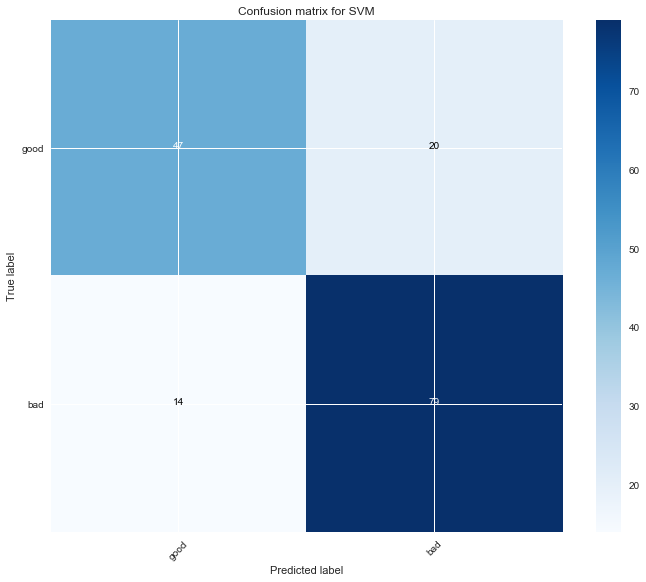

In [45]:
X_train, X_test, y_train, y_test = JJ.get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)
parameter_tuning(X_train, X_test, y_train, y_test, 2, patid = '231', C_range_num = 100, 
                     nfold = 10, if_save = 0, if_show = 1)

In [42]:
X_train.shape

(638, 28)

In [39]:

X_train, X_test, y_train, y_test = JJ.get_ml_data(data, '231', if_scaler = 1, if_remove_icd = 1)
#parameter_tuning(X_train, X_test, y_train, y_test, classifier = 1, C_range_num = 100, if_save = 1)
JJ.ensemble_model(X_train, y_train, X_test, y_test, patid = '231', if_save = 0)

0.825


In [97]:
1

1